# Tirage du salaire dans l'erfs-fpr

*Objectif* : récupérer la distribution du salaire en fonction de différentes variables socio-démographiques

*Application* : récupération de la distribution en fonction de l'âge et du sexe

*Méthode* : On étudie dans un premier temps une modalité d'une variable ( la modalité "homme" de la variable "sexe") afin d'acquérir une automitisation du traitement sur d'autres variables

*Résultat* : Le souci de ce script c'est qu'il ne peut tourner que sur un ordi ayant accès aux données ERFS-fpr. Pour pouvoir utiliser la distribution aléatoire générée, nous exportons un nombre ad-hoc de salaires simulés, pensé en fonction de la taille de la population mère qu'on recherche.

In [1]:
%pylab inline
import pandas as pd
import numpy as np
import tables
import mpld3
import json

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
import statsmodels.api as sm
import seaborn as sns
from Tools import *
from kde_2d_weighted import gaussian_kde

#### Chargement des tables

In [3]:
individu = get_individu_simplified(get_individu('output/erfs_fpr_2012.h5'))

In [4]:
# On se concentre sur les individus actifs
activite = individu[individu.acteu6 == 1] 

## Étude d'un filtre : le sexe

In [5]:
salaire = get_salaire(activite, 'sexe')
salaire.size()

#  Sexe : 1 si homme
#         2 si femme

sexe
1    26158
2    24597
dtype: int64

On se concentre sur la modalité `homme`

#### Etude des outliers : définition de max_salaire

In [6]:
max_salaire = 400000
print(len(salaire.get_group(1)[salaire.get_group(1) > max_salaire]) / 26158.0)
# justification de ne pas prendre ne compte les plus riches pour une meilleure approximation

0.000535209113847


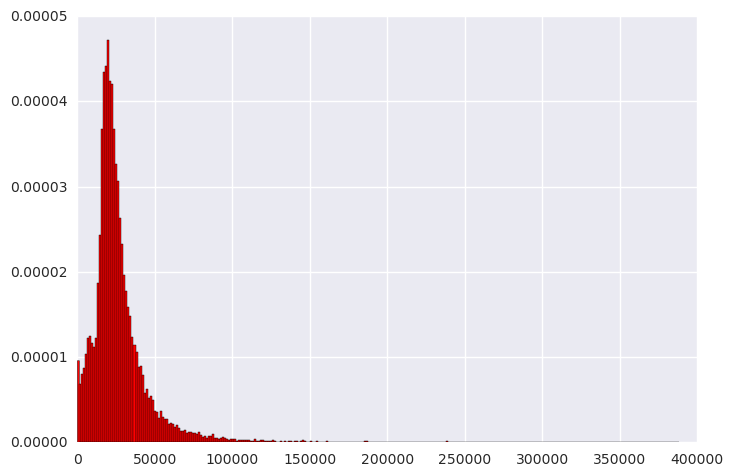

("Nombre d'observations", 23111)


In [7]:
plt.hist(salaire.get_group(1)[(salaire.get_group(1) > 0) &(salaire.get_group(1) < max_salaire)], bins = 300, normed = True, facecolor='red')
plt.show()
print("Nombre d'observations", len(salaire.get_group(1)[(salaire.get_group(1) > 0) &(salaire.get_group(1) < max_salaire)]))

# On choisit délibérement de ne pas prendre les salaires égaux à zero pour attribuer un salaire (salaire égal à zero dû notamment aux indépendants actifs)

#### Étude de l'impact des poids

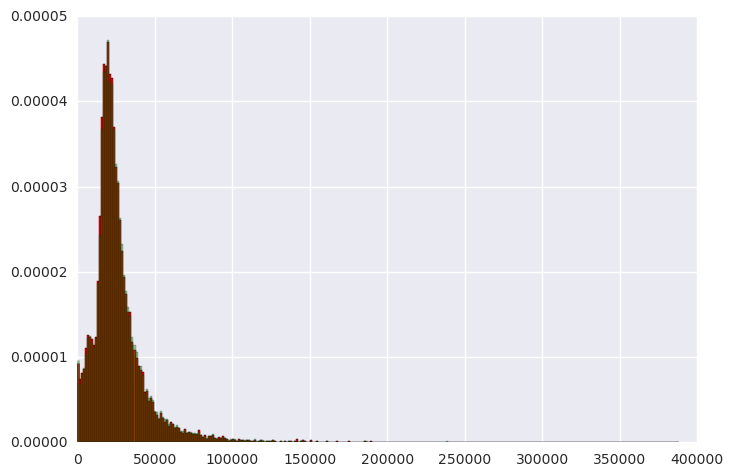

In [8]:
plt.hist(salaire.get_group(1)[(salaire.get_group(1) > 0) &(salaire.get_group(1) < max_salaire)], bins = 300, weights = get_weights(activite[(activite.salaires_i > 0) & (activite.salaires_i < max_salaire)], 'sexe').get_group(1), normed = True, facecolor='red')
plt.hist(salaire.get_group(1)[(salaire.get_group(1) > 0) & (salaire.get_group(1) < max_salaire)], bins = 300,normed = True, facecolor='green',  alpha = 0.4)
plt.show()
# on abandonne l'utilisation des poids pour simplifier la démarche

### Estimer la distribution

In [9]:
X = np.array(salaire.get_group(1)[(salaire.get_group(1) > 0) & (salaire.get_group(1) < max_salaire)])
X_plot = np.linspace(0, max_salaire, 10000)[:, np.newaxis]

#### Choix du bandwidth : règle de Scott

In [10]:
bw = sm.nonparametric.bandwidths.bw_scott(X)
bw

1524.7149140812714

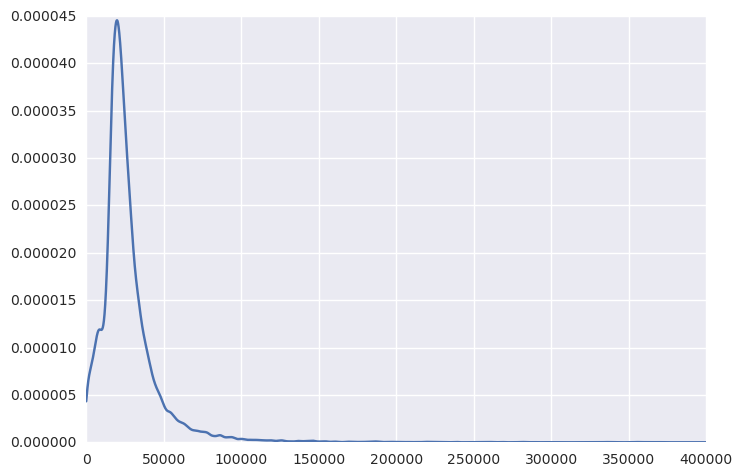

In [11]:
# Présentation de la démarche : exemple avec une kde gaussienne
kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(X.reshape(-1,1))
log_dens = kde.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens))

#### Choix du kernel : comparaison entre Gaussien, Tophat et Epanechnikov

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(X, bins = 300, histtype= 'stepfilled', fc='black', alpha=0.2, normed= True,
        label='input distribution')

for kernel in ['gaussian', 'tophat', 'epanechnikov']:
    kde = KernelDensity(kernel=kernel, bandwidth=bw).fit(X.reshape(-1,1))
    log_dens = kde.score_samples(X_plot)
    ax.plot(X_plot[:, 0], np.exp(log_dens), '-',
            label="kernel = '{0}'".format(kernel))


ax.legend(loc='upper right', prop={'size':10})

mpld3.display()
# En utlisant le zoom, on se rend compte que le kernel Tophat est légèrement mieux 
# notamment sur les valeurs proches de 0

#### Tirage d'un échantillon

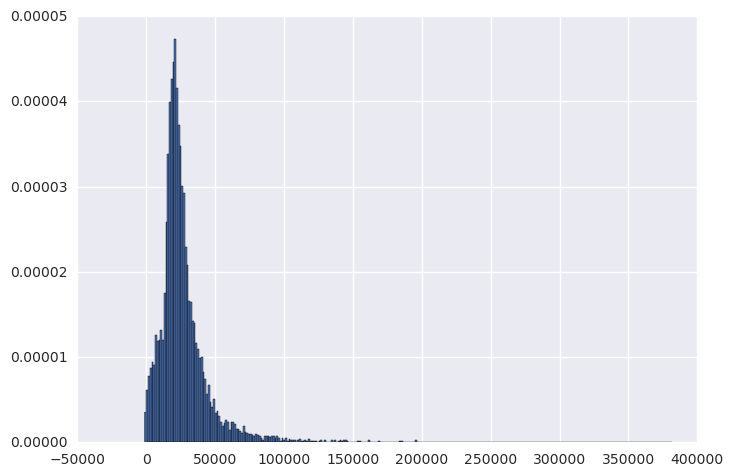

In [13]:
kde_tophat = KernelDensity(kernel='tophat', bandwidth=bw).fit(X.reshape(-1,1))
plt.hist(kde_tophat.sample(10000), bins = 300, normed = True)
plt.show()

#### Changement de modalité, même méthode

In [ ]:
# Salaire des femmes
Y = np.array(salaire.get_group(2)[(salaire.get_group(2) > 0) & (salaire.get_group(2) < max_salaire)])

In [17]:
# Distribution du salaire des hommes
pd.Series(X).describe()

count     23111.000000
mean      27392.221886
std       21918.247494
min          10.000000
25%       17150.000000
50%       22810.000000
75%       31640.000000
max      388040.000000
dtype: float64

In [18]:
# Distribution du salaire des femmes
pd.Series(Y).describe()

count     22616.000000
mean      19771.974708
std       13142.948128
min          10.000000
25%       12160.000000
50%       18170.000000
75%       24730.000000
max      281300.000000
dtype: float64

In [14]:
bw = sm.nonparametric.bandwidths.bw_scott(Y)
print(bw)
print("Nombre d'observations", len(Y))

1328.42221316
("Nombre d'observations", 22616)


In [15]:
def compare_kde(data, data_plot, bw, title = ''):
    '''
    Creer un graphique de comparaison entre les kernels
    '''
    fig, ax = plt.subplots(figsize=(6,3))
    ax.hist(data, bins = 300, histtype= 'stepfilled', fc='black', alpha=0.2, normed= True,
            label='input distribution')
    for kernel in ['gaussian', 'tophat']:
        kde = KernelDensity(kernel=kernel, bandwidth=bw).fit(data.reshape(-1,1))
        log_dens = kde.score_samples(data_plot)
        ax.plot(data_plot[:, 0], np.exp(log_dens), '-',
                label="kernel = '{0}'".format(kernel))
    ax.legend(loc='upper right', prop={'size':7})
    ax.set_title(title)

compare_kde(Y, X_plot, bw)
mpld3.display()


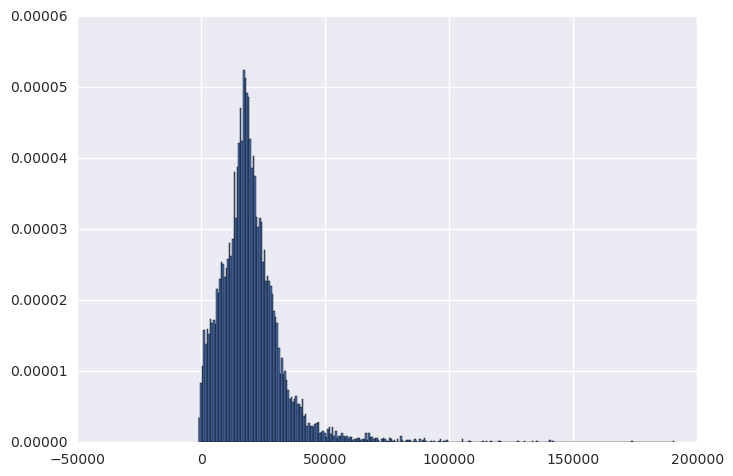

In [16]:
kde_tophat = KernelDensity(kernel='tophat', bandwidth=bw).fit(Y.reshape(-1,1))
plt.hist(kde_tophat.sample(10000), bins = 300, normed = True)
plt.show()

## Filtre : sexe et âge

In [36]:
# Chercher les catégories les moins représentées afin de gonfler leur effectif pour limiter l'overfitting
# Pas d'automatisation 
a = activite.groupby(('age')).size()
a.sort_values()[:40]

age
88      1
84      1
79      1
86      1
83      2
78      2
77      2
82      3
81      3
14      3
80      4
76      7
74      8
73     12
75     12
72     16
71     17
70     34
15     37
69     38
68     54
67     59
66     91
16    104
17    122
65    132
64    203
18    204
63    284
19    297
62    311
61    425
20    442
21    546
22    597
60    714
23    732
24    792
25    852
26    871
dtype: int64

In [82]:
activite.loc[activite['sexe'] == 1, 'sexe'] = 'homme'
activite.loc[activite['sexe'] == 2, 'sexe'] = 'femme'

In [83]:
# Regroupement selon la variable âge
activite['age_pivot'] = activite['age']
activite.loc[activite.age <= 23, 'age_pivot'] = '<23'
activite.loc[activite.age >= 60, 'age_pivot'] = '>60'

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [84]:
salaire = get_salaire(activite, ['sexe', 'age_pivot'])

#### Définir l'intervalle de salaire pris en compte

In [85]:
salaire_filtre = {}
for filtre in salaire.groups.keys():
    condition = (salaire.get_group(filtre) > 0) &(salaire.get_group(filtre) < max_salaire)
    salaire_filtre['{0}'.format(filtre)] = np.array(salaire.get_group(filtre)[condition])

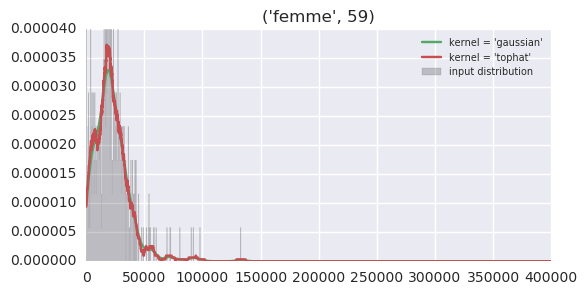

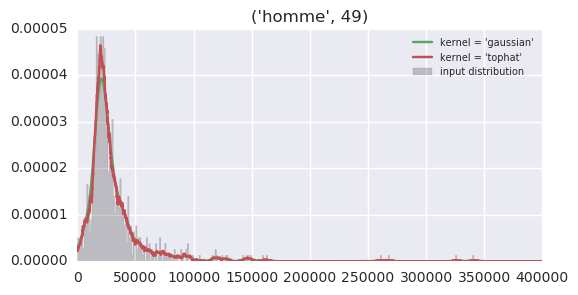

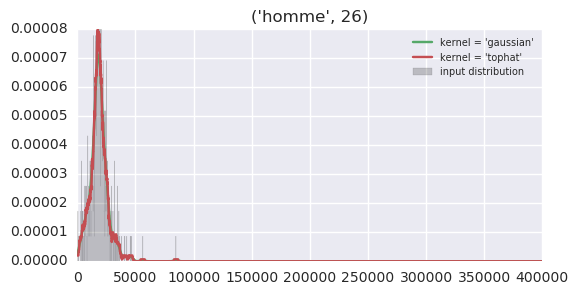

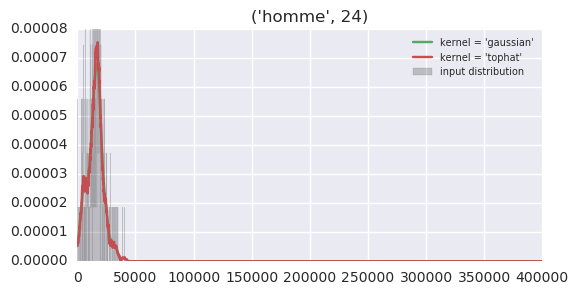

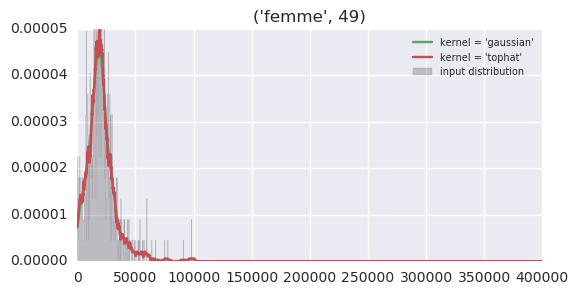

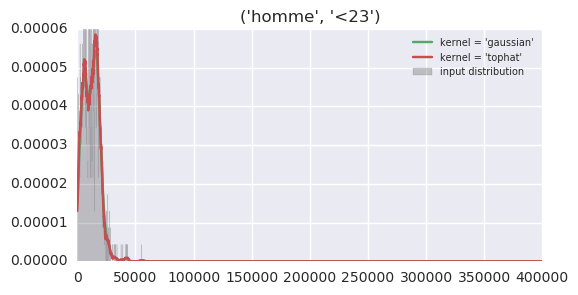

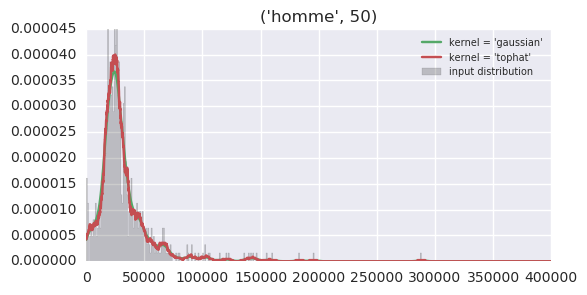

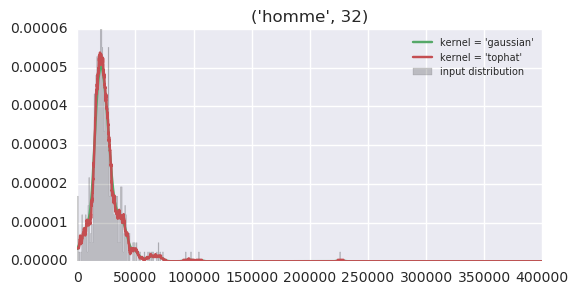

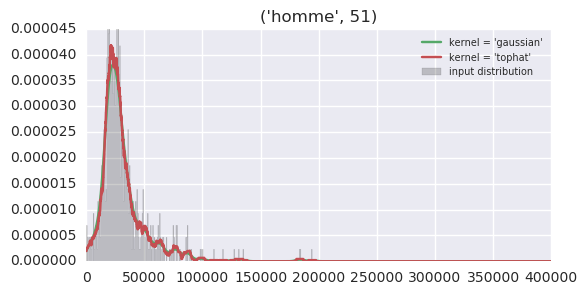

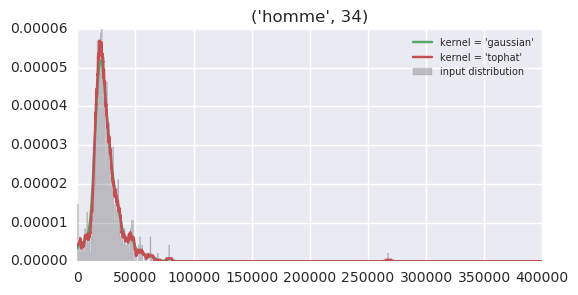

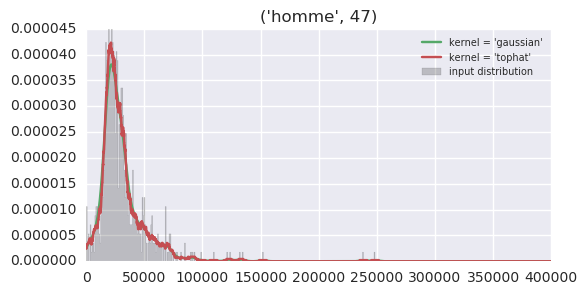

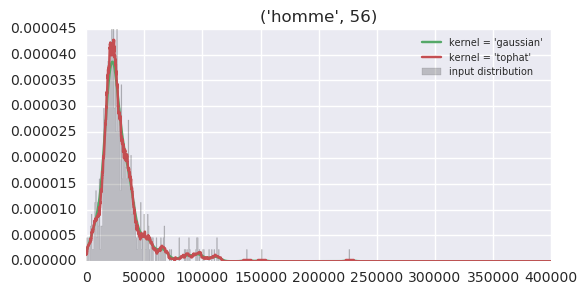

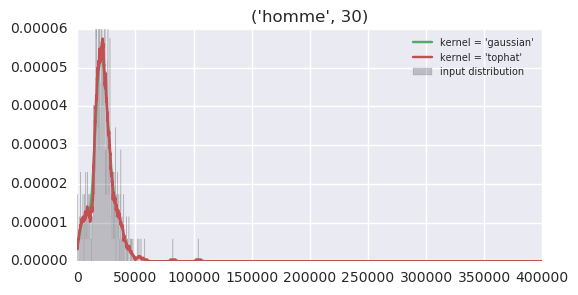

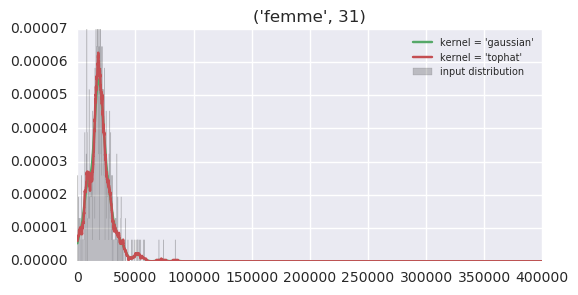

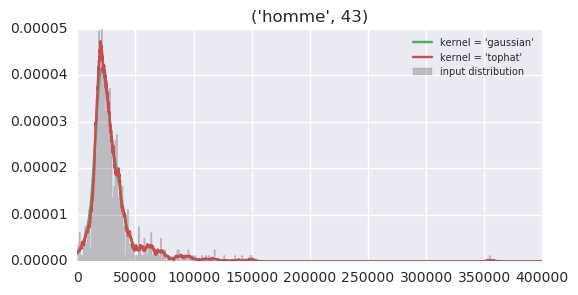

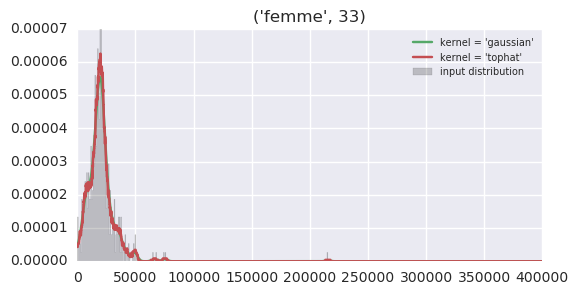

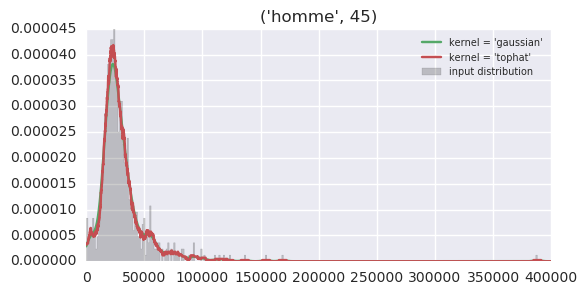

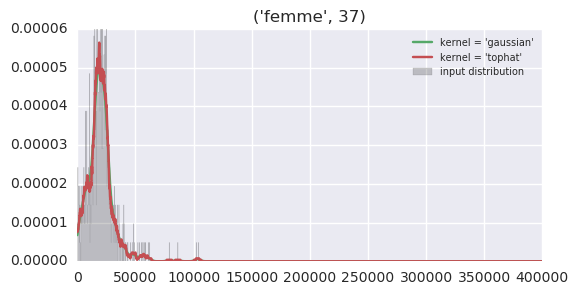

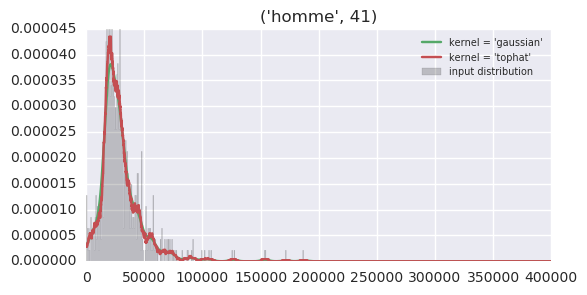

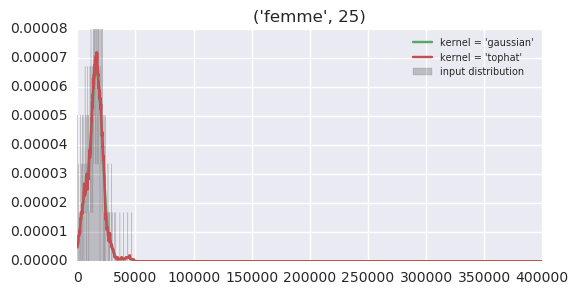

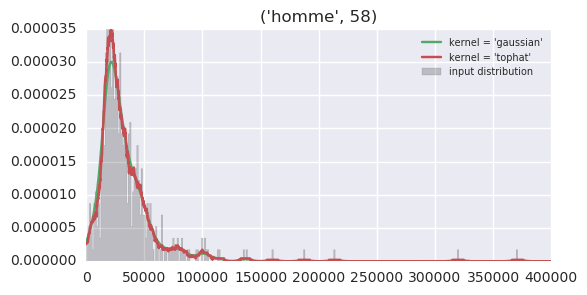

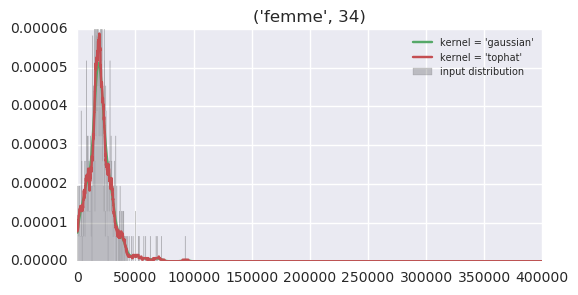

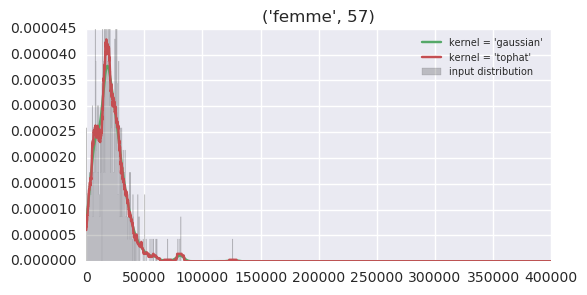

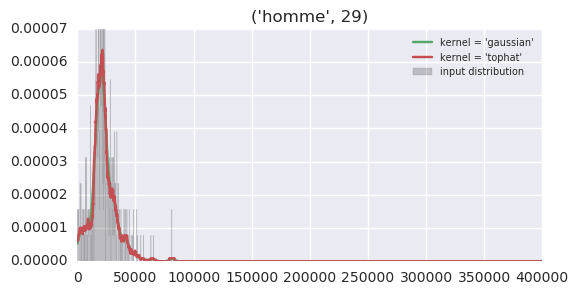

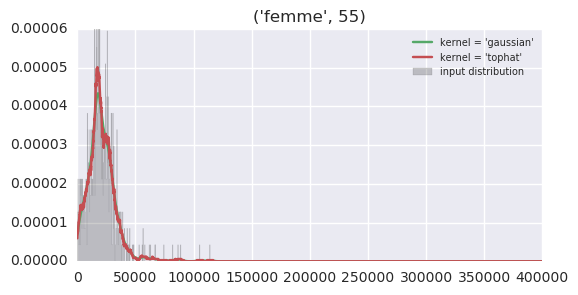

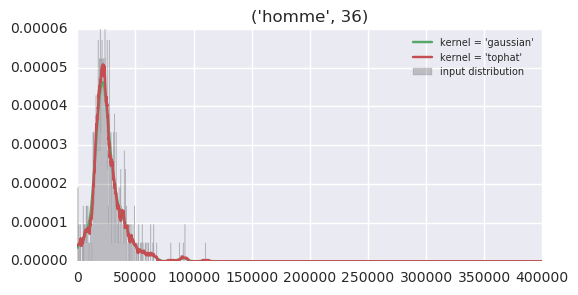

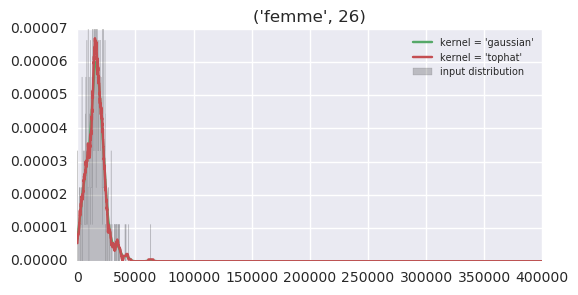

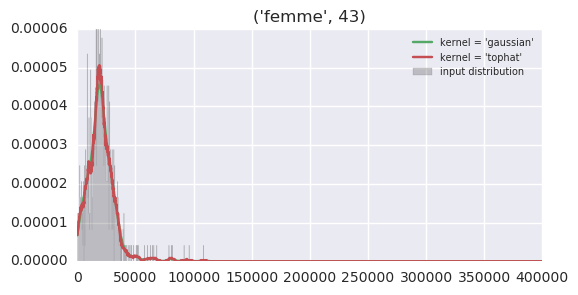

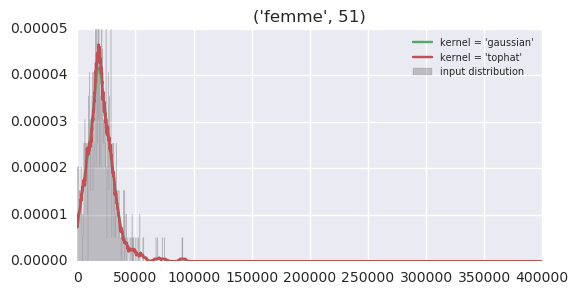

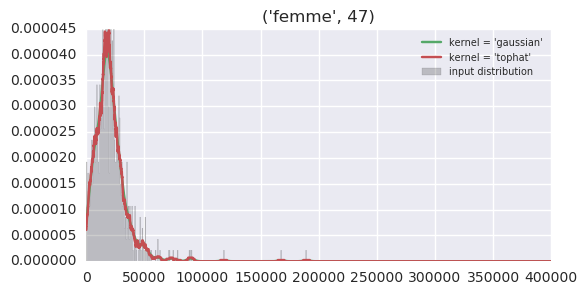

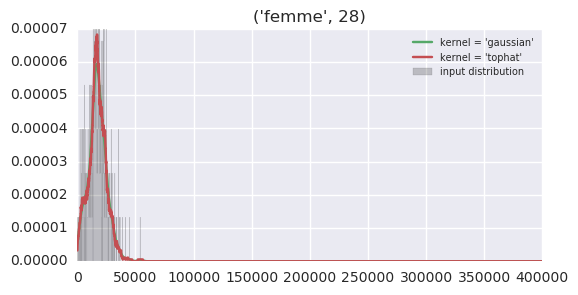

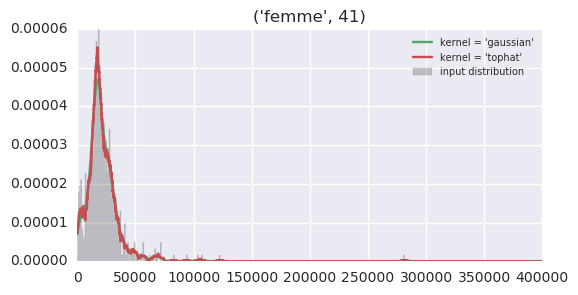

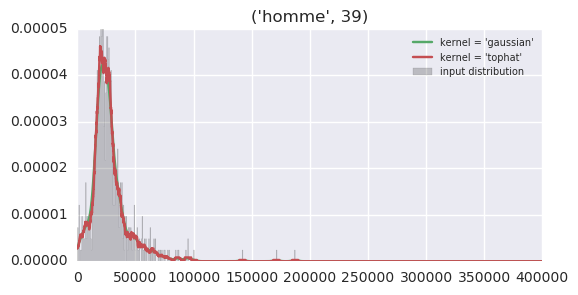

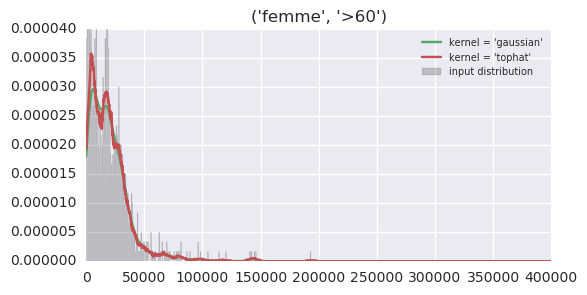

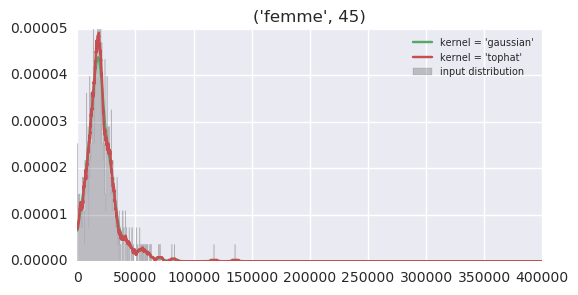

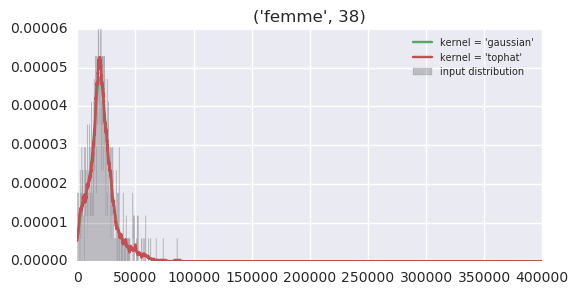

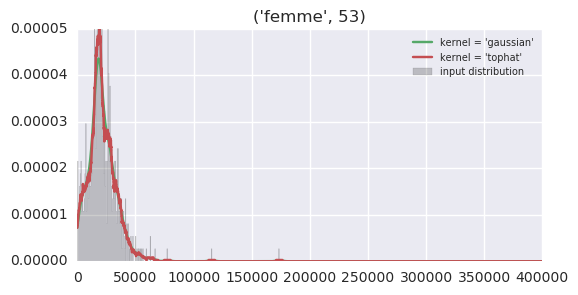

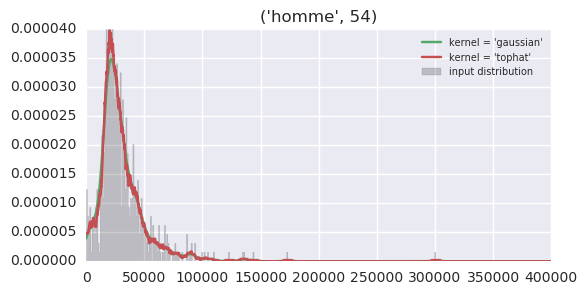

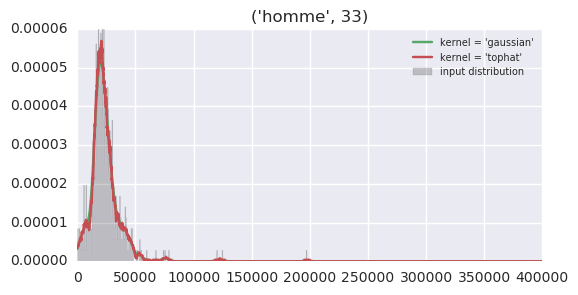

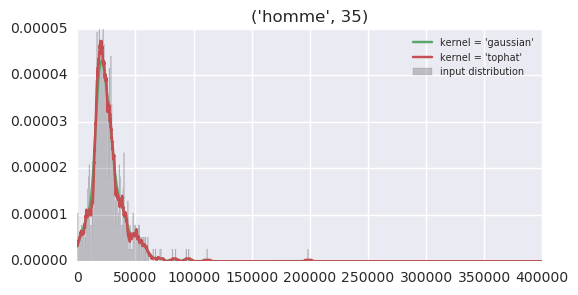

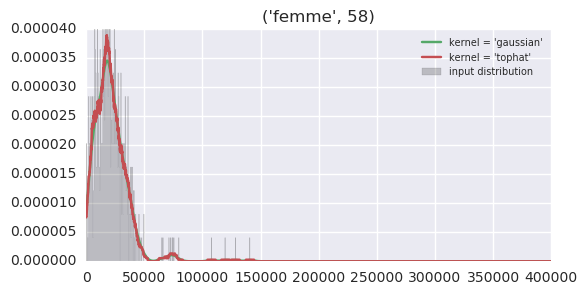

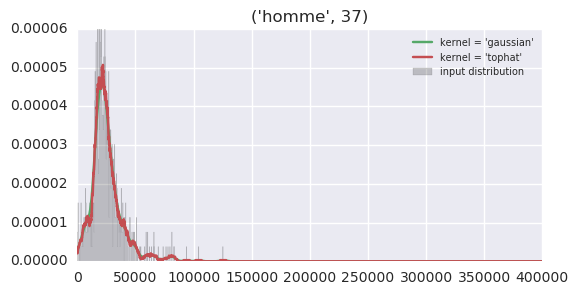

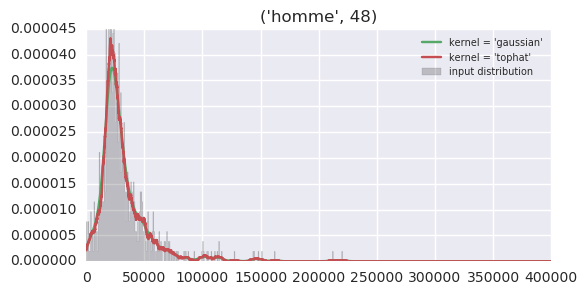

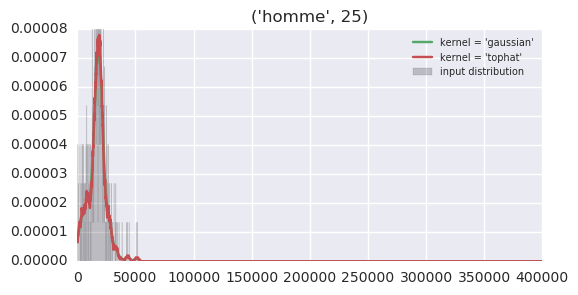

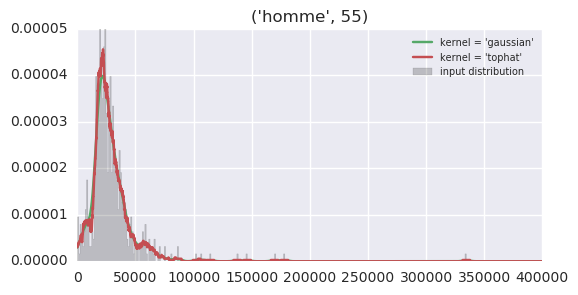

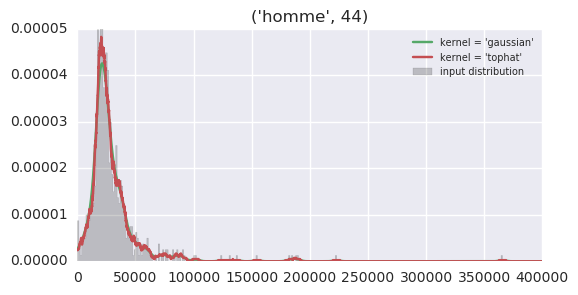

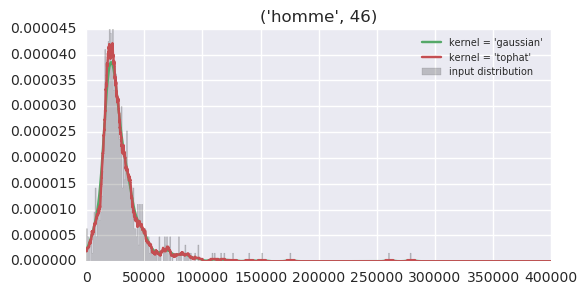

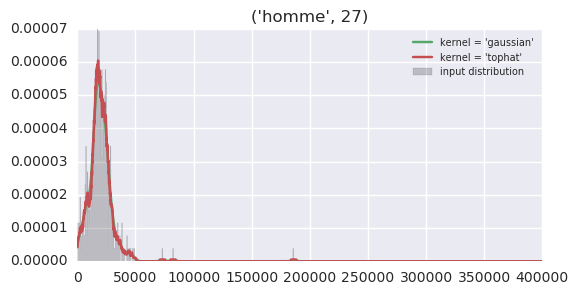

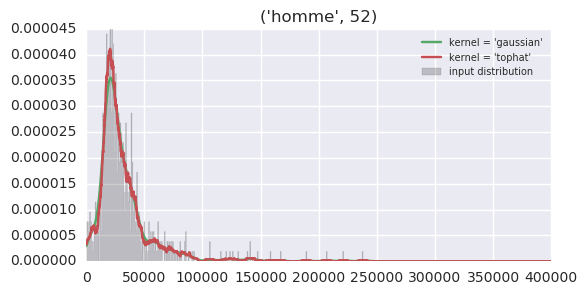

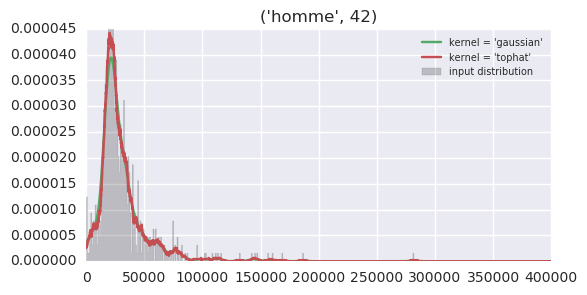

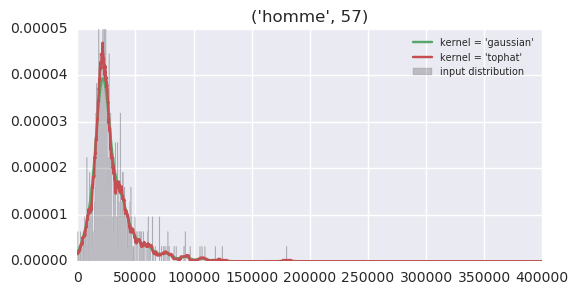

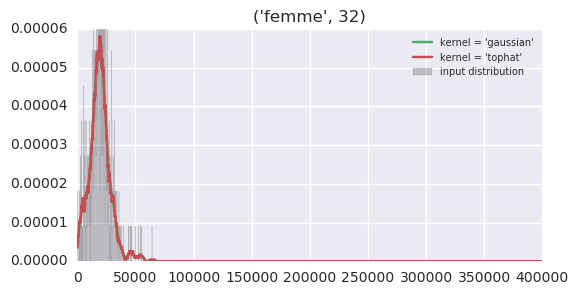

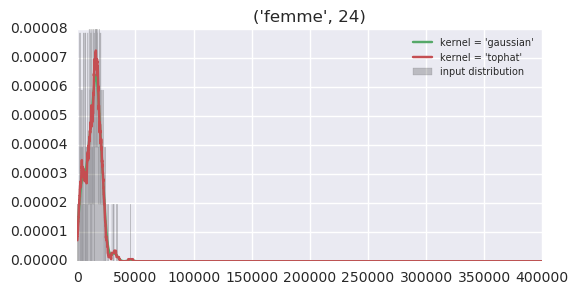

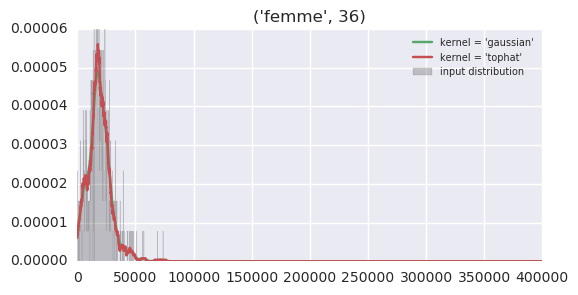

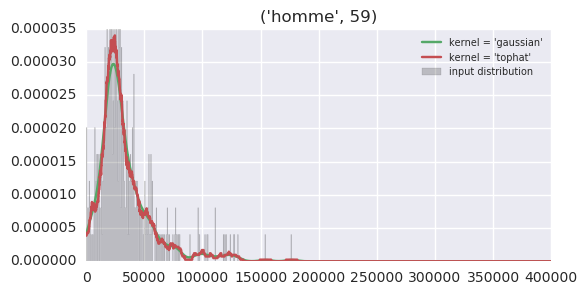

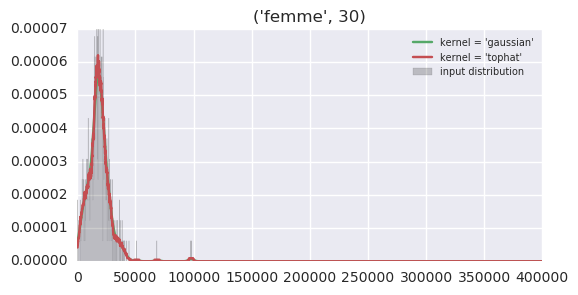

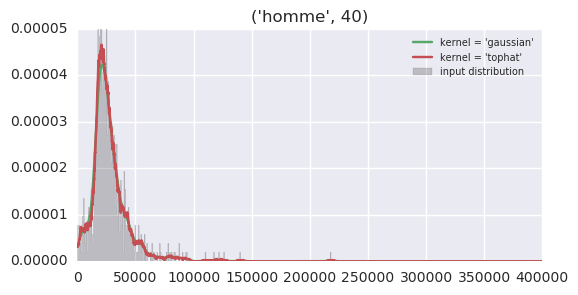

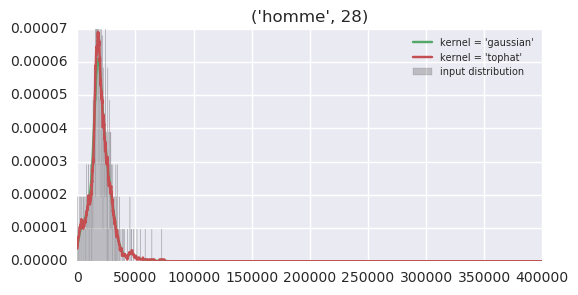

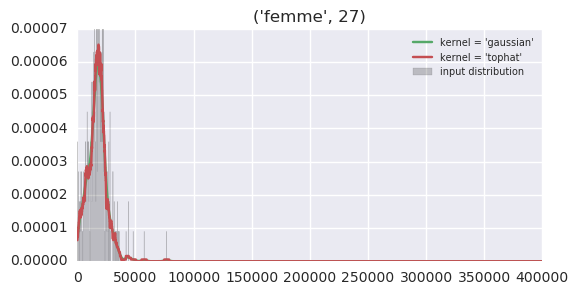

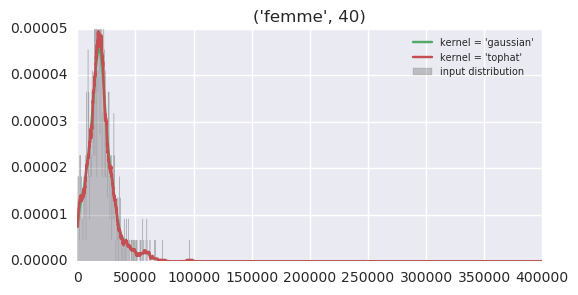

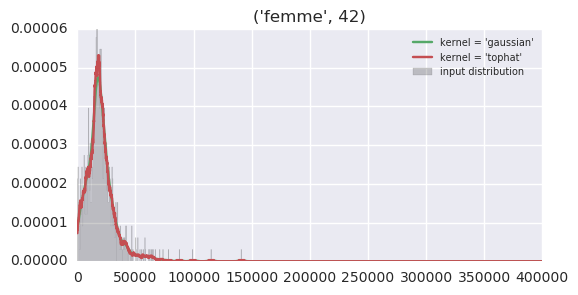

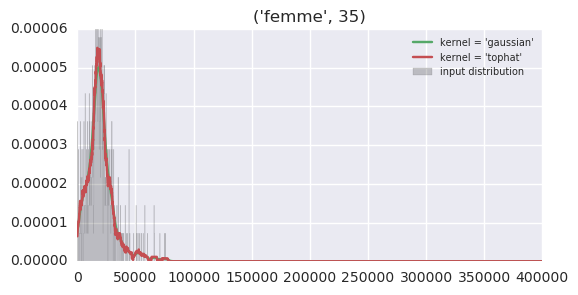

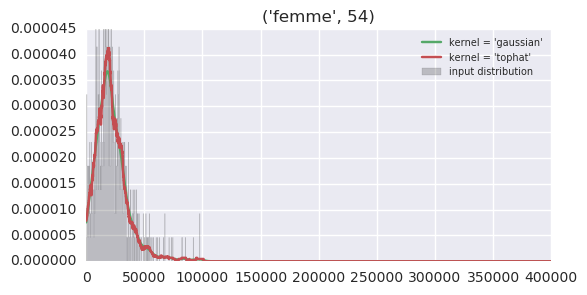

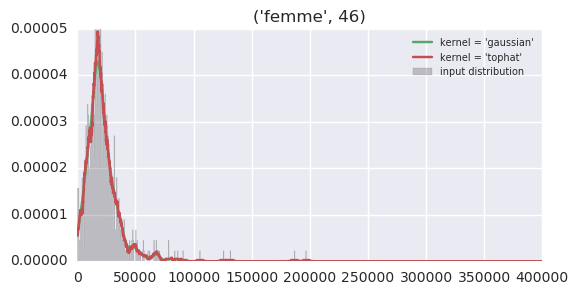

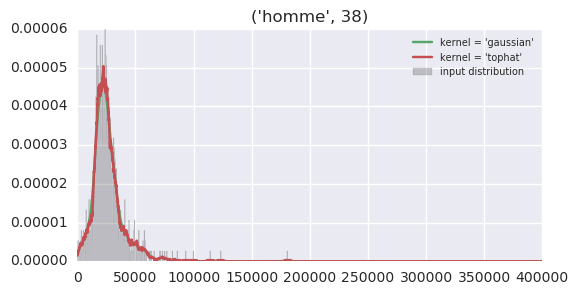

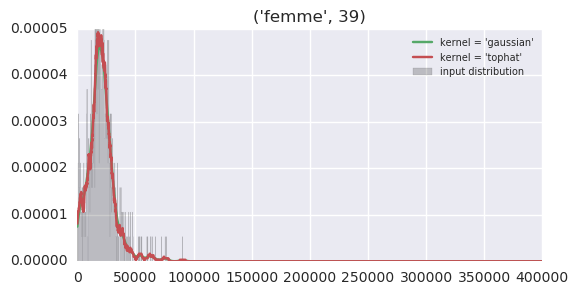

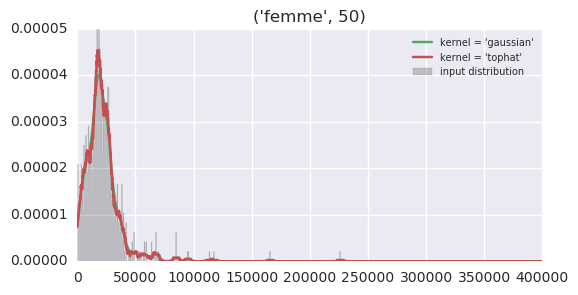

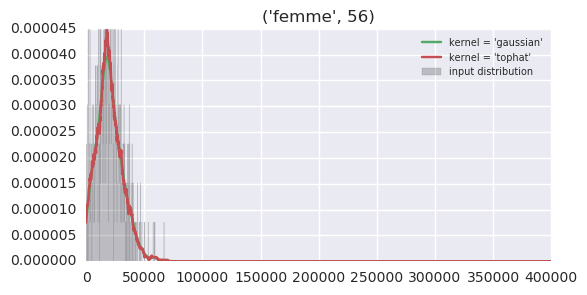

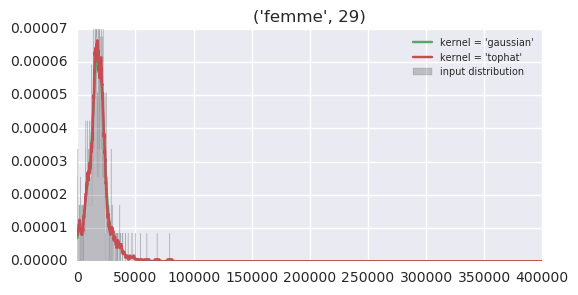

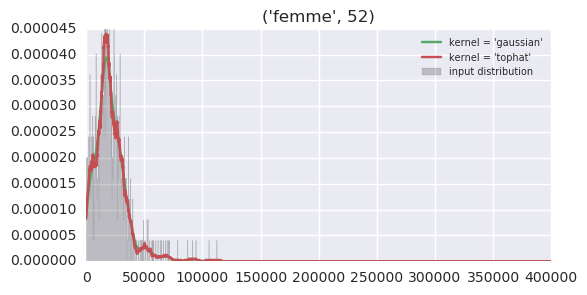

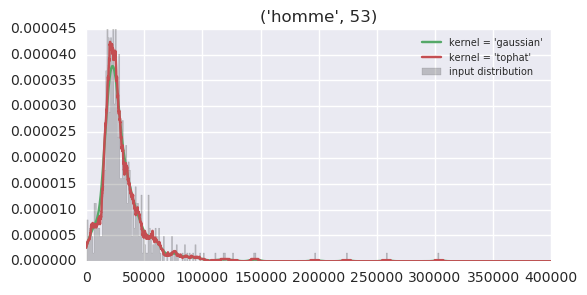

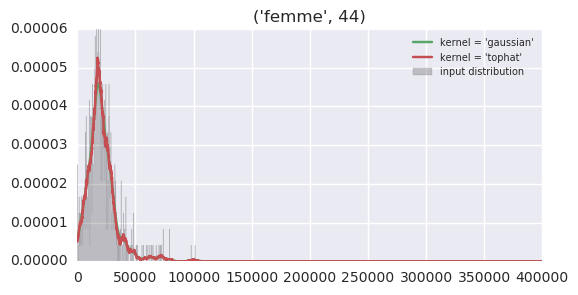

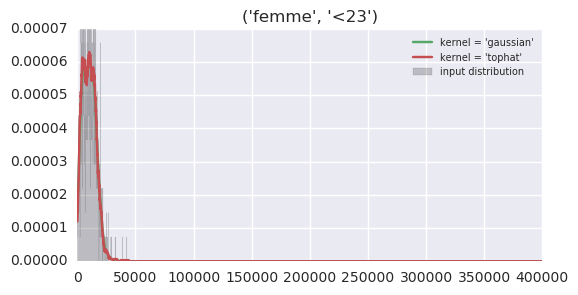

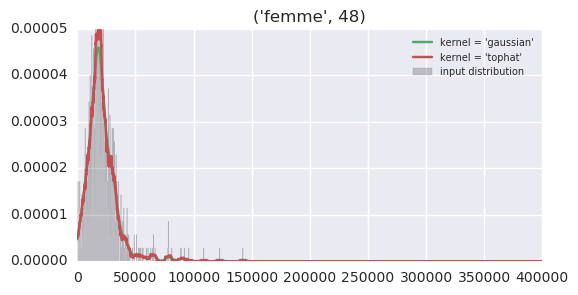

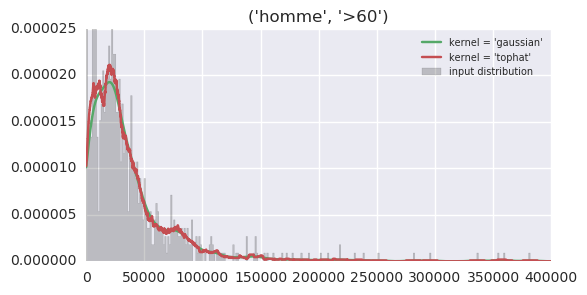

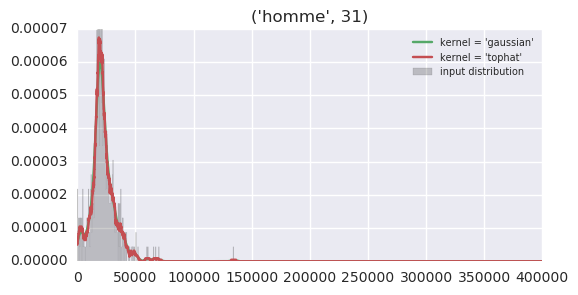

In [86]:
kde_sample = {}
kde_plot = {}
for filtre in salaire_filtre.keys():
    X = salaire_filtre[filtre]
    bw = sm.nonparametric.bandwidths.bw_scott(X)
    kde = KernelDensity(kernel='tophat', bandwidth=bw).fit(X.reshape(-1,1))
    # Tirage d'un échantillon : taille définie en fonction de la taille de la population simulée
    kde_sample['{0}'.format(filtre)] = [float(x) for x in kde.sample(10000)]
    compare_kde(X, X_plot, bw, filtre)


#### Export pour réutilisation

In [87]:
with open('salaire_sexe_age.json', 'w') as fp:
    json.dump(kde_sample, fp)